In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

In [2]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')

data

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand
...,...,...,...,...,...,...,...,...,...,...
3540957,55520,1424778496409,205449746189955,4.416595,-8.708023,-1.715271,i,lgwatch,lgwatch_2,bike
3540958,55521,1424778496409,205449751164320,5.337799,-9.526871,-1.222534,i,lgwatch,lgwatch_2,bike
3540959,55522,1424778496409,205449756138686,6.580353,-9.748245,-1.291565,i,lgwatch,lgwatch_2,bike
3540960,55523,1424778496409,205449761143569,7.932404,-9.514969,-1.608154,i,lgwatch,lgwatch_2,bike


In [3]:
data = data[['x', 'y', 'z', 'gt']]


In [4]:
data['gt'].unique()

array(['stand', nan, 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [5]:
data_without_nan = data.dropna(subset=['gt'])

In [6]:
data_without_nan['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [7]:
# Define the classes
classes = ['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike']

# Initialize an empty list to store sampled data
sampled_data = []

# Iterate over each class
for class_name in classes:
    # Filter the DataFrame for the current class
    class_data = data[data['gt'] == class_name]
    
    # Sample 1000 rows for the current class
    sampled_class_data = class_data.sample(n=1000, replace=True)  # Set replace=True if there are less than 1000 samples
    
    # Append the sampled data to the list
    sampled_data.append(sampled_class_data)

# Concatenate the sampled data for all classes into a single DataFrame
sampled_df = pd.concat(sampled_data)

print("Sampled DataFrame with 1000 samples for each class:")
print(sampled_df)

Sampled DataFrame with 1000 samples for each class:
                x         y         z     gt
2028993  8.896713  3.274322  1.813034  stand
424888  -4.043243  2.008408  5.968567  stand
443696  -9.077728  3.422348 -0.082336  stand
3145898 -2.311602 -4.630386  7.912238  stand
1050261  8.696762 -3.992950  1.491684  stand
...           ...       ...       ...    ...
417985  -9.010818 -3.290741  5.892990   bike
421687  -9.970108 -2.609955  5.907272   bike
29535   -7.237073 -1.086369  5.783793   bike
1942603 -9.327667 -0.062515  3.266846   bike
1874507  2.467331 -7.413544  5.921555   bike

[6000 rows x 4 columns]


In [8]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 2028993 to 1874507
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       6000 non-null   float64
 1   y       6000 non-null   float64
 2   z       6000 non-null   float64
 3   gt      6000 non-null   object 
dtypes: float64(3), object(1)
memory usage: 234.4+ KB


In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'gt' column in the sampled DataFrame
sampled_df['label'] = label_encoder.fit_transform(sampled_df['gt'])

# Inverse transform to get the original labels if needed
# original_labels = label_encoder.inverse_transform(sampled_df['label'])

num_classes = len(label_encoder.classes_)

print("Encoded labels:")
print(sampled_df[['gt', 'label']].head())

Encoded labels:
            gt  label
2028993  stand      4
424888   stand      4
443696   stand      4
3145898  stand      4
1050261  stand      4


In [10]:
sampled_df.head()

,x,y,z,gt,label
2028993,8.896713,3.274322,1.813034,stand,4
424888,-4.043243,2.008408,5.968567,stand,4
443696,-9.077728,3.422348,-0.082336,stand,4
3145898,-2.311602,-4.630386,7.912238,stand,4
1050261,8.696762,-3.992950,1.491684,stand,4


In [11]:
sampled_df = sampled_df.drop(columns='gt',axis=1)

In [12]:
sampled_df.head()

,x,y,z,label
2028993,8.896713,3.274322,1.813034,4
424888,-4.043243,2.008408,5.968567,4
443696,-9.077728,3.422348,-0.082336,4
3145898,-2.311602,-4.630386,7.912238,4
1050261,8.696762,-3.992950,1.491684,4


In [13]:
def data_preparing(df, winSize):
    X = []
    y = []
    
    for i in range(len(df) - winSize):
        features = df.iloc[i:i+winSize, :-1].values  # Slice the DataFrame based on winSize
        target = df.iloc[i + winSize, -1]

        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y)

In [14]:
X, y = data_preparing(sampled_df, 100)


In [15]:
X.shape

(5900, 100, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)

(4720, 100, 3)
(1180, 100, 3)


In [18]:
N_train = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

N_test = X_test.shape[0]

In [19]:
X_train = X_train.reshape(N_train, T, D)
X_test = X_test.reshape(N_test, T, D)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4720, 100, 3)
(4720,)
(1180, 100, 3)
(1180,)


In [21]:
from torch.utils.data import DataLoader,TensorDataset

# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

In [22]:
for x,y in train_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 100, 3])
torch.Size([32])


In [23]:
print(y)

tensor([2, 1, 3, 5, 1, 1, 2, 2, 5, 2, 2, 0, 2, 2, 2, 2, 5, 0, 1, 1, 5, 3, 3, 1,
        1, 0, 3, 2, 3, 5, 2, 3])


In [24]:
for x,y in test_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 100, 3])
torch.Size([32])


In [25]:
class LSTM_model(nn.Module):
  def __init__(self,input_size, num_hidden, num_layers):
    super().__init__()

    # Define  parameters

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # LSTM Layer

    self.lstm = nn.LSTM(input_size,num_hidden,num_layers, batch_first = True)

    # Output Layer

    self.out = nn.Linear(num_hidden,6)

  def forward(self,x):

    y, (h,c) = self.lstm(x)
    out = self.out(y)    # Output shape (batch, features, hidden)
    out = out[:,-1,:]    # Reshaped to (batch, hidden)

    return out, (h,c)

In [26]:
# Define LSTM model
input_size = 3  # Number of features per time step
hidden_size = 250
num_layers = 1

In [27]:
# Instantiate the model
lstmModel = LSTM_model(input_size=3, num_hidden=250, num_layers=1)

In [28]:
lstmModel

LSTM_model(
  (lstm): LSTM(3, 250, batch_first=True)
  (out): Linear(in_features=250, out_features=6, bias=True)
)

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [30]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [31]:
epochs = 30

# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(lstmModel.parameters(), momentum = 0.9, lr = 0.01)

lstmModel.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# Inside the training loop
for epoch in range(epochs):
    lstmModel.train()
    
    batchAcc = []
    batchLoss = []
    
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        
        ypred, h = lstmModel(X)
        loss = lossfunc(ypred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batchLoss.append(loss.item())
        
        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc.item())
    
    trainAcc.append(np.mean(batchAcc))
    losses[epoch] = np.mean(batchLoss)
    
    if epoch % 10 == 0:
        print(f'Epochs: {epoch}, Loss: {loss.item():.2f}')
    
    # Testing the model
    lstmModel.eval()
    test_batchAcc = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            
            ypred, _ = lstmModel(X)  # Assigning the second value to `_`
            
            acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
            test_batchAcc.append(acc.item())
    
    testAcc.append(np.mean(test_batchAcc))


Epochs: 0, Loss: 0.97
Epochs: 10, Loss: 0.25
Epochs: 20, Loss: 0.01


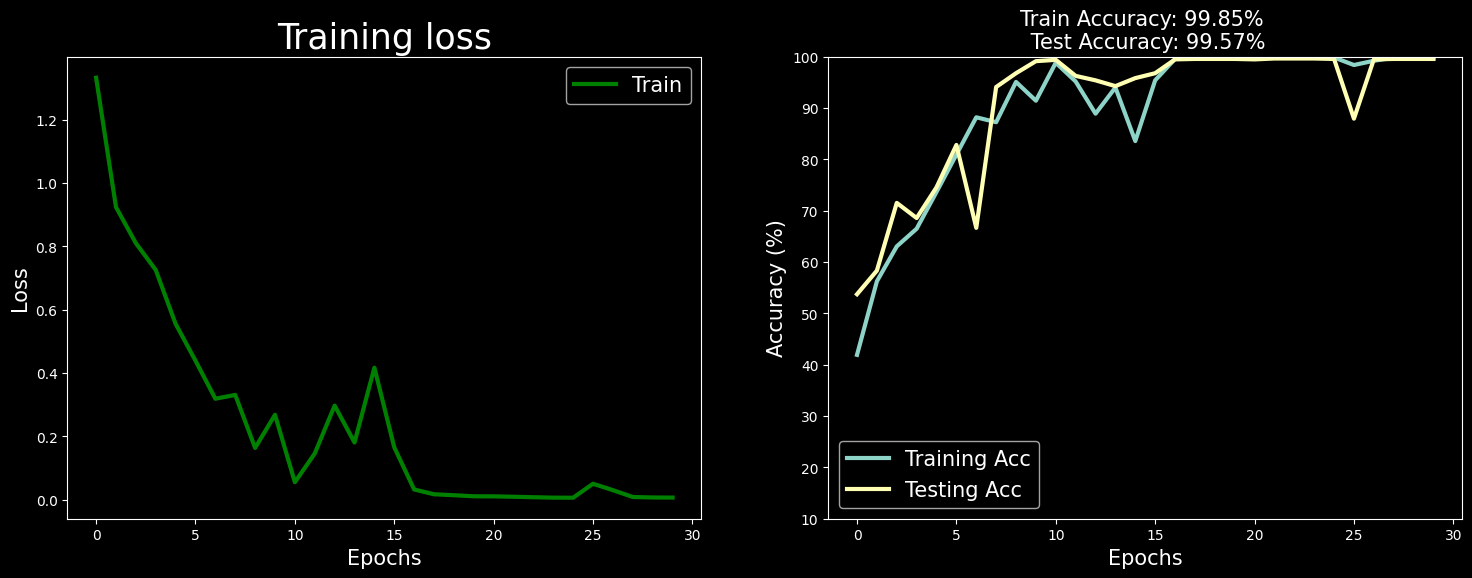

In [32]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()